In [1]:
# importing relevant libraries
import pandas as pd
import numpy as np
import gurobipy as gp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

GUROBI_TIMEOUT = 5 # in second
%matplotlib inline

In [2]:
# Reading the data file
df = pd.read_csv('price_demand_data.csv')
print(df.shape)
df.head()

(99, 2)


,price,demand
0,1.05,283
1,0.86,771
2,1.21,185
3,0.94,531
4,0.76,1002


# Q1) Fit a linear regression model to the data set. 

Coefficients for the regression model are 1924.7175435291088 -1367.7125241625981


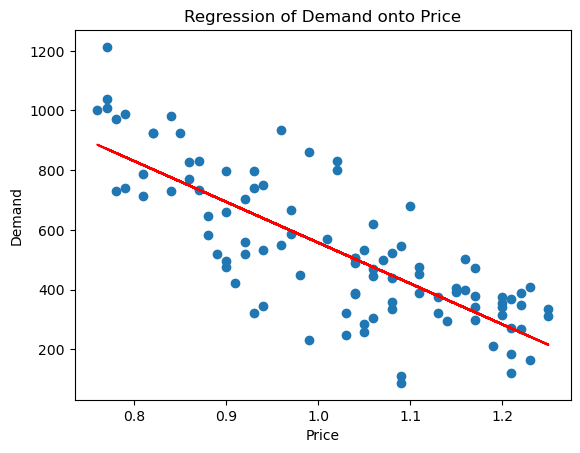

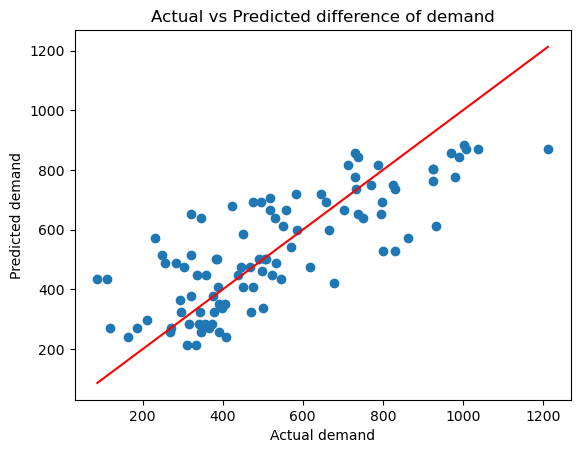

In [3]:
# fitting linear regression
lr = LinearRegression()
lr.fit(df[['price']], df['demand'])
# storing the intercept as beta0 and the first coefficient as beta1
beta0 = lr.intercept_
beta1 = lr.coef_[0]
print('Coefficients for the regression model are', beta0, beta1)
# Predicting demand based on regression equation
df['predicted_demand'] = beta0 + beta1*df['price']

# plotting regression of demand vs price
plt.figure()
plt.scatter(df['price'], df['demand'])
plt.plot(df['price'], df['predicted_demand'], color='red')
plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Regression of Demand onto Price')
plt.show()

# plotting the trendline between actual and predicted demand
plt.figure()
plt.scatter(df['demand'], df['predicted_demand'])
plt.xlabel('Actual demand')
plt.ylabel('Predicted demand')

line = np.arange(df['demand'].min(), df['demand'].max())
plt.plot(line, line, color='red')
plt.title('Actual vs Predicted difference of demand')

plt.show()

# Q2) Assume the price is p=1 and generate demand data. 

In [4]:
# calculating residuals
new_df = pd.DataFrame()
new_df['residuals'] = df['demand'] - df['predicted_demand']

# calculating demand using regression coefficients and residual with price = 1
p = 1
new_df['price'] = p
new_df['demand'] = beta0 + beta1*new_df['price'] + new_df['residuals']

# Q3) Solve the optimal quantity to produce when p=1

In [5]:
n = len(new_df)
# regular printing cost
c = 0.5
# rush order printing cost
g = 0.75
# disposal cost
t = 0.15
# price
p = 1

In [6]:
'''
optimize quantity (q) such that each day's profit (-H) is being maximized
In other words, our decision variables are:
q, h1, ... ,h_n (till the number of days)

For each day ranging from 1 to nday, it is subject to the following conditions:

q * [c-g] + h <= p*Di - g*Di when Di >= q (demand greater than quanity produced)
q * [c+t] + h <= p*Di + t*Di when Di < q (demand less than quanity produced)

'''

# init A, b, sense
A = np.zeros((n*2, n+1))
b = np.zeros(A.shape[0])
sense = ['<']*A.shape[0]
obj = np.zeros(A.shape[1])

# constraint matrix size
print('Shape of constraint matrix', A.shape)
print('Shape of b', b.shape)

# ensuring bounds
lb = [0] + [-np.inf]*n
ub = [np.inf] + list((p+t)*new_df['demand'].values)

obj[1:] = 1/n

# decision variables - q, h1, h2, ....h99
for i in range(n):
    d = new_df.loc[i ,'demand']
    
    A[i, [0, i+1]] = [c-g, 1]
    b[i] = p*d - g*d
    
    A[n+i, [0, i+1]] = [c+t, 1]
    b[n+i] = p*d + t*d

Shape of constraint matrix (198, 100)
Shape of b (198,)


In [7]:
# creating gurobi model with constraints
p1_nv = gp.Model()
p1_nv_x = p1_nv.addMVar(len(obj),lb=lb, ub=ub) # tell the model how many variables there are

p1_nv_con = p1_nv.addMConstrs(A, p1_nv_x, sense, b) 
p1_nv.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model

p1_nv.Params.OutputFlag = 0 # tell gurobi to shut up!!
p1_nv.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-17


In [8]:
# profit and optimal quantity for fixed price model
q = p1_nv.x[0]
exp_profit = p1_nv.objVal

print('Optimal Quantity is ', q)
print('Expected profit is ', exp_profit)

Optimal Quantity is  471.8653795908935
Expected profit is  231.4836666471413


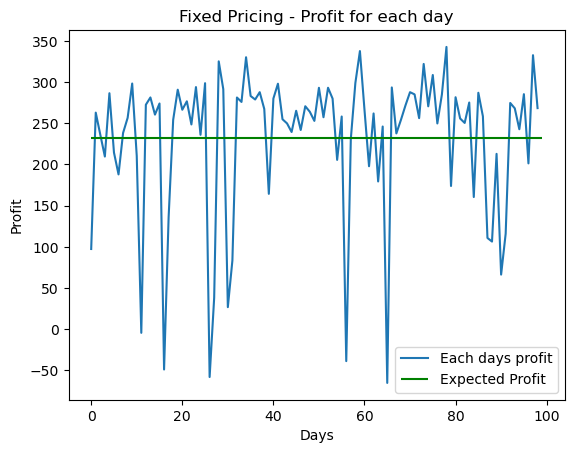

In [9]:
new_df['quantity'] = q
new_df['profit'] = np.where(
    new_df['demand'] > q,
    p*new_df['demand'] - g*new_df['demand'] - (c-g)*q,
    p*new_df['demand'] + t*new_df['demand'] - (c+t)*q)

plt.figure()
plt.title('Fixed Pricing - Profit for each day')
plt.xlabel('Days')
plt.ylabel('Profit')
plt.plot(new_df['profit'])
plt.hlines(exp_profit, 0, 99, color='green')
plt.legend(['Each days profit', 'Expected Profit'])
plt.show()

# Q4) Now let price impact demand and solve the resulting QP

In [10]:
def optimal_price_profit(res, beta0, beta1):
    n = len(res)
    # init A, b, sense
    # decision variables - [q, p, h1, h2, ... h99]
    A = np.zeros((n*2, n+2))
    b = np.zeros(A.shape[0])
    sense = ['<']*A.shape[0]
    obj = np.zeros(A.shape[1])
    Q = np.zeros((A.shape[1], A.shape[1]))

    # bounds
    lb = [0] + [0] + [-np.inf]*n
    ub = [np.inf] + [np.inf] + [np.inf]*n

    obj[1] = beta0 + np.mean(res)
    obj[2:] = 1/n

    Q[1, 1] = beta1

    for i in range(n):
        eps = res[i]

        A[i, [0, 1, i+2]] = [c-g,  g*beta1, 1]
        b[i] = -g*beta0 - g*eps 

        A[n+i, [0, 1, i+2]] = [c+t, -t*beta1, 1]
        b[n+i] = t*beta0 + t*eps
    
    model = gp.Model()
    model_x = model.addMVar(len(obj),lb=lb, ub=ub)

    model_con = model.addMConstr(A, model_x, sense, b) 
    model.setMObjective(Q,obj,0,sense=gp.GRB.MAXIMIZE)

    model.Params.OutputFlag = 0 # 
    model.optimize()
    
    return model

In [11]:
res = new_df['residuals'].values

In [12]:
dynamic_price_nv = optimal_price_profit(res, beta0, beta1)

In [13]:
optimal_quantity, optimal_price = np.round(dynamic_price_nv.x[0], 2), np.round(dynamic_price_nv.x[1], 2)
print('Optimal quantity is', optimal_quantity, 'Optimal price is', optimal_price)

Optimal quantity is 535.29 Optimal price is 0.95


In [14]:
expected_profit = np.round(dynamic_price_nv.objVal, 2)
print('Expected Profit is', expected_profit)

Expected Profit is 234.42


In [15]:
beta0, beta1, res.shape

(1924.7175435291088, -1367.7125241625981, (99,))

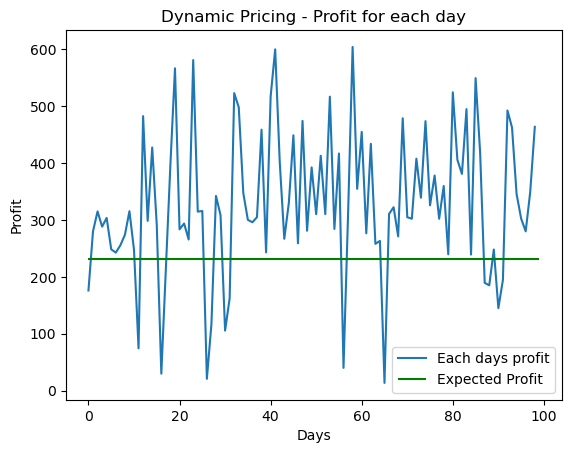

In [16]:
demand_data = df.copy()
# creating demand as a function of optimal price
# calculating the profit based on the formula give in the problem statement
demand_data['quantity'] = optimal_quantity
demand_data['price'] = optimal_price
demand_data['opt_demand'] = beta0 + beta1*optimal_price + res
demand_data['profit'] = np.where(
    demand_data['demand'] > optimal_quantity,
    p*demand_data['opt_demand'] - g*demand_data['opt_demand'] - (c-g)*q,
    p*demand_data['opt_demand'] + t*demand_data['opt_demand'] - (c+t)*q)

plt.figure()
plt.title('Dynamic Pricing - Profit for each day')
plt.xlabel('Days')
plt.ylabel('Profit')
plt.plot(demand_data['profit'])
plt.hlines(exp_profit, 0, 99, color='green')
plt.legend(['Each days profit', 'Expected Profit'])
plt.show()

# Q5) - Not Applicable as we have solved using QP

# Q6)  fit new beta’s to the new bootstrapped dataset and redo step 4.  Find the optimal price and quantity

In [17]:
'''Defining linear regression model for bootstrapped data'''
def lm_output(df):
    lm = LinearRegression()
    lm.fit(df[['price']], df['demand'])
    beta0 = lm.intercept_
    beta1 = lm.coef_[0]

    pred = beta0 + beta1*df['price']
    
    res = (df['demand'] - pred).values
    
    return res, beta0, beta1

In [18]:
# Bootstrapped data using randomizaton

idx = np.random.choice(np.arange(len(df)), size=n)
subset_df = df.iloc[idx]
residuals, beta0, beta1 = lm_output(subset_df)
bootstrap_m = optimal_price_profit(residuals, beta0, beta1)

print('The optimal quantity is' ,bootstrap_m.x[0])
print('The optimal price is', bootstrap_m.x[1])
print('The expected profit is', bootstrap_m.objVal)

The optimal quantity is 596.1446674364241
The optimal price is 0.9399572064487091
The expected profit is 240.28307908068405


# Q7) Make histograms of the optimal price and quantity.  

In [19]:
# Taking samples = size
bs_sample = n
bs_n = 10000
quantity = []
price = []
profit = []

#bootstraping using the random function with sample size = number of days
for i in range(bs_n):
    idx = np.random.choice(np.arange(len(df)), size=bs_sample)
    subset_df = df.iloc[idx]
    residuals, beta0, beta1 = lm_output(subset_df)
    bootstrap_m = optimal_price_profit(residuals, beta0, beta1)
    quantity.append(bootstrap_m.x[0])
    price.append(bootstrap_m.x[1])
    profit.append(bootstrap_m.objVal)
    
final_df = pd.DataFrame({'profit': profit, 'price': price, 'quantity': quantity})

<Figure size 640x480 with 0 Axes>

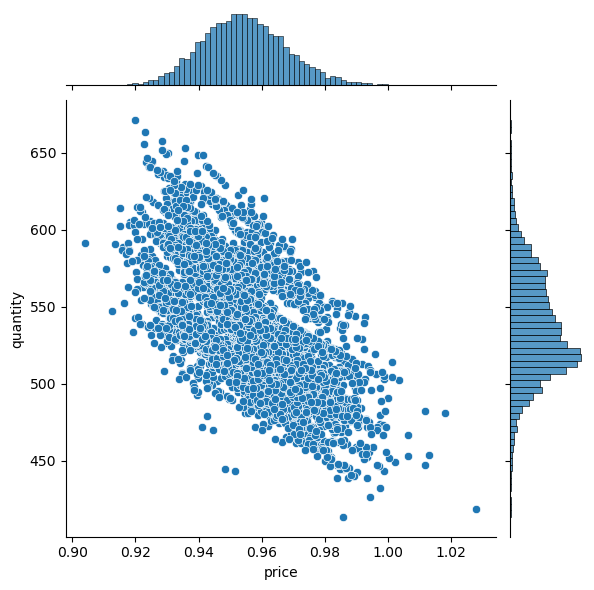

In [20]:
plt.figure()
sns.jointplot(x='price', y='quantity', data=final_df)
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

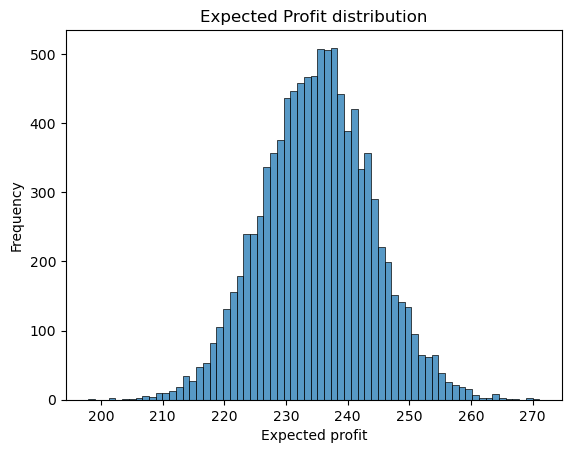

In [21]:
plt.figure()
sns.histplot(final_df['profit'])
plt.xlabel('Expected profit')
plt.ylabel('Frequency')
plt.title('Expected Profit distribution')
plt.show()

# 8 Standard Model from class

In [22]:
demand_df = pd.read_csv('price_demand_data.csv')
nd = demand_df.shape[0] # number of days of demand data
cost = 0.5
price = 1.00
# decision variables are (q, h1, h2, ..., h25)
obj = np.zeros(nd+1)
obj[1:] = 1.0/nd
lb = np.zeros(nd+1)
lb[1:] = -np.inf # quantity printed needs to be non-negative, but profit on a given day could possibly be negative
rhs = np.zeros(2*nd)
direction = np.array(['<']*(2*nd))
A = np.zeros((2*nd,nd+1))
for r in range(nd):
    A[2*r,[0,r+1]] = [cost,1] # location 1 is q, location r+1 is this h
    rhs[2*r] = price*demand_df.demand[r]
    A[2*r+1,[0,r+1]] = [cost-price,1]
    rhs[2*r+1] = 0
spMod = gp.Model()
spMod_x = spMod.addMVar(len(obj),lb=lb) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
spMod_con = spMod.addConstr(A @ spMod_x <= rhs) # NAME THE CONSTRAINTS!!! so we can get information about them later!
spMod.setObjective(obj @ spMod_x,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

spMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
spMod.optimize()


In [23]:
spMod_x.x[0]

490.0

In [24]:
spMod.objval

168.3737373737375

In [25]:
numsold = np.minimum(spMod_x.x[0],demand_df.demand) # on each day, how many did we actually sell
np.mean(price*numsold - cost*spMod_x.x[0]) # what was the average profit? exactly equal to the objective value!

168.37373737373738